<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io
from skimage.transform import resize
import os
import pandas as pd
from IPython.display import clear_output

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    #all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, df

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...


--2021-12-27 17:42:30--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  272K 6m30s
    50K .......... .......... .......... .......... ..........  0%  545K 4m52s
   100K .......... .......... .......... .......... ..........  0% 48.5M 3m16s
   150K .......... .......... .......... .......... ..........  0% 44.8M 2m27s
   200K .......... .......... .......... .......... ..........  0%  552K 2m36s
   250K .......... .......... .......... .......... ..........  0% 60.7M 2m10s
   300K .......... .......... .......... .......... ..........  0% 53.6M 1m52s
   350K .......... .......... .......... .......... ..........  0% 61.4M 98s
   400K ......

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2021-12-27 17:42:38--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-12-27 17:42:38--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  323K 45s
    50K .......... .......... .......... .......... ..........  0%  648K 34s
   100K .......... .......... .......... .......... ..........  1% 54.7M 22s
   150K .......... .......... ..........

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
data_train,data_val=train_test_split(data,test_size=0.3,random_state=42)
print (f'Размер трейна:{len(data_train)} \n Размер вала:{len(data_val)}')

Размер трейна:9200 
 Размер вала:3943


In [ ]:
class AutoencodersDataset (Dataset):
    def __init__(self,data):
        super().__init__()
        self.data=data
    def __getitem__(self,idx):
        return torch.tensor(self.data[idx],dtype=torch.float).permute(2,0,1)
    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset=AutoencodersDataset(data_train)
val_dataset=AutoencodersDataset(data_val)
train_dataloader=DataLoader(train_dataset,batch_size=20)
val_dataloader=DataLoader(val_dataset,batch_size=20)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self,dim_code):
        super().__init__()
      
        self.encoder = nn.Sequential(
            # enc 1 64x64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # enc 2 32x32
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
           
            # e3 16x16
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2,  padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8x8
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=16384, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=dim_code)
        )
         
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=16384),
            nn.Unflatten(dim=1, unflattened_size=(256, 8, 8)),
            # dec 1
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # d2
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # d3
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2) )
        
    def forward(self, x):
        
        #<реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>
        latent_code=self.encoder(x)
        reconstruction=self.decoder(latent_code)
        return reconstruction,latent_code

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder(dim_code).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from IPython.display import clear_output

In [ ]:
def train_model(model,optimizer,criterion,train_dataloader,val_dataloader,epochs=20):
    history={'train_loss':[], 'val_loss':[]}
    for i in range (epochs):
        print (f'^_^ Epoch №{i+1} ^_^')
        avg_loss_train=0
        avg_loss_val=0
        model.train()
        for X in train_dataloader:
            X=X.to(device)
            optimizer.zero_grad()
            X_hat=model(X)[0]
            loss=criterion(X_hat,X)
            loss.backward()
            optimizer.step()
            avg_loss_train+=loss.item()/len(data_train)
        history['train_loss'].append(avg_loss_train)
        with torch.no_grad():
            model.eval()
            for X_val in val_dataloader:
                X_val=X_val.to(device)  
                X_val_hat=model(X_val)[0]
                loss=criterion(X_val_hat,X_val)
                avg_loss_val+=loss.item()/len(data_val)
        history['val_loss'].append(avg_loss_val)
        print ('Train loss: %.6f \n Val loss: %.6f'% (avg_loss_train,avg_loss_val))
        clear_output(wait=True)
        X_val=next(iter(val_dataloader))
        X_val=X_val.to(device) 
        X_val_hat=model(X_val)[0]
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3))
            plt.title('Real image')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(np.rollaxis(X_val_hat[k].detach().cpu().numpy(), 0, 3))
            plt.title('Predict image')
            plt.axis('off')

        plt.suptitle('%d / %d - val loss %f' % (i+1, epochs, avg_loss_val))
        fig, ax = plt.subplots()
    
        
        ax.plot(history['train_loss'], label='train loss')
        ax.plot(history['val_loss'], label='val loss')
        ax.set_xlabel("epochs")
        ax.set_ylabel("loss")
        ax.legend(loc='best')
        ax.set_title('Loss plots')
        
        
        plt.show()

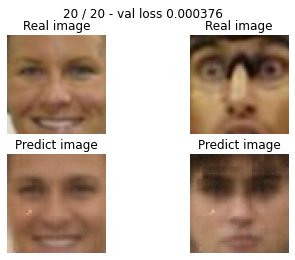

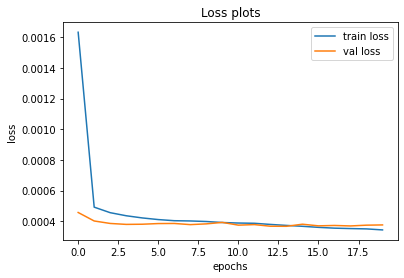

In [ ]:
train_model(autoencoder,optimizer,criterion,train_dataloader,val_dataloader)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
X=next(iter(val_dataloader))
X_hat=autoencoder(X.to(device))[0]

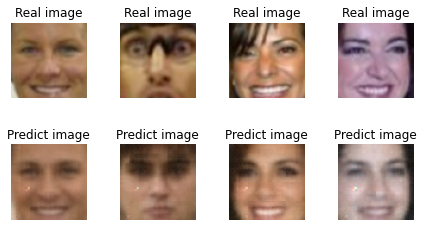

In [ ]:
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.tight_layout()
    plt.imshow(np.rollaxis(X[k].cpu().numpy(), 0, 3))
    plt.title('Real image')
    plt.axis('off')
    
    #plt.subplots_adjust(wspace=1.5, hspace=1.5)
    
    plt.subplot(2, 4, k+5)
    plt.tight_layout()
    plt.imshow(np.rollaxis(X_hat[k].detach().cpu().numpy(), 0, 3))
    plt.title('Predict image')
    plt.axis('off')
    #plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)*32+10
z=torch.tensor(z).to(device).float()
output=autoencoder.decoder(z)
#<выведите тут полученные картинки>

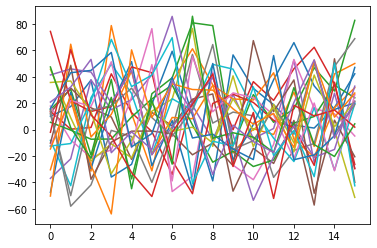

In [ ]:
for i in range(25):
    plt.plot(z[i].cpu().numpy())
plt.show()

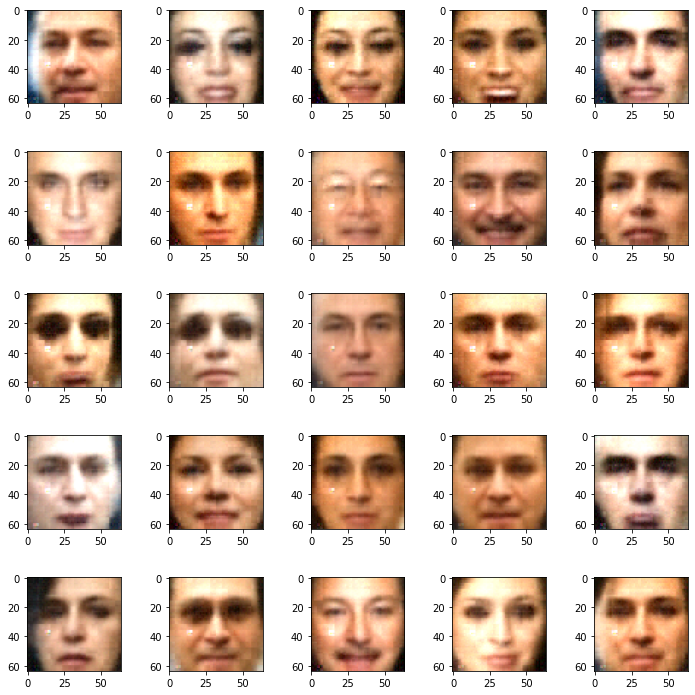

In [ ]:
fig,axes=plt.subplots(5,5,figsize=(10,10))
plt.tight_layout()
for k in range (25):
    axes[k //5][k%5].imshow(output[k].detach().cpu().permute(1,2,0))

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
dx,dy=80,80
dimx=64
dimy=64
smiling_images=(attrs[attrs['Smiling']>2.2].iloc[:20]['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))).values
unsmiling_images=(attrs[(attrs['Smiling']<0) & (attrs['Smiling']>-1)].iloc[:20]['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))).values


In [ ]:
smiling=[img for img in smiling_images]
unsmiling=[img for img in unsmiling_images]
smiling_images=torch.tensor(smiling).to(device).float().permute(0,3,1,2)
unsmiling_images=torch.tensor(unsmiling).to(device).float().permute(0,3,1,2)

In [ ]:
smiling_vector=torch.mean(autoencoder(smiling_images)[1])
unsmiling_vector=torch.mean(autoencoder(unsmiling_images)[1])

In [ ]:
diff=smiling_vector-unsmiling_vector

In [ ]:
unsmile_peoples=unsmiling_images
unsmile_latents=autoencoder(unsmile_peoples)[1]
new_latents=unsmile_latents+diff
new_peoples=autoencoder.decoder(new_latents)

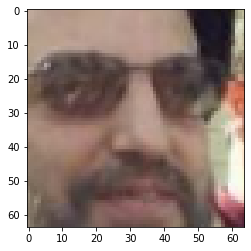

In [ ]:
plt.imshow(unsmile_peoples[3].cpu().permute(1,2,0))

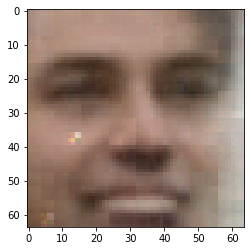

In [ ]:
plt.imshow(new_peoples[3].detach().cpu().permute(1,2,0))

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
  
        self.encoder = nn.Sequential(
            #28x28
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2,  padding=0),
        
         nn.ReLU(),
            #14x14
         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2,  padding=0),
        
         nn.ReLU(),
         #7x7
         nn.Flatten(),
         nn.Linear(3136,26)
        )

    
        self.decoder = nn.Sequential(
            nn.Linear(13,3136),
            nn.Unflatten(dim=1, unflattened_size=(64, 7, 7)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            
            nn.Sigmoid()
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        
        x=x.view(-1,2,13)
        mu = x[:,0,:]
        logsigma = x[:,1,:]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
           
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
  
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):

        mu, logsigma = self.encode(x)
        latent = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(latent)
        
        return reconstruction, mu,logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5*torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    x=x.to(device)
    reconstruction=reconstruction.to(device)
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    KL_loss=KL_divergence(mu,logsigma)
    
    log_likelihood_loss=log_likelihood(x,reconstruction)
    return KL_loss+log_likelihood_loss

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder_vae = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder_vae.parameters())

In [ ]:
def train_model_vae(model,optimizer,criterion,train_dataloader,val_dataloader,epochs=20):
    history={'train_loss':[], 'val_loss':[]}
    for i in range (epochs):
        print (f'^_^ Epoch №{i+1} ^_^')
        avg_loss_train=0
        avg_loss_val=0
        model.train()
        for X,y in train_dataloader:
            X=X.to(device)
            optimizer.zero_grad()
            X_hat,mu,logsigma=model(X)
            loss=criterion(X,mu,logsigma,X_hat)
            loss.backward()
            optimizer.step()
            avg_loss_train+=loss.item()/len(train_dataloader)
        history['train_loss'].append(avg_loss_train)
        with torch.no_grad():
            model.eval()
            for X_val,y_val in val_dataloader:
                X_val=X_val.to(device)  
                X_val_hat,mu,logsigma=model(X)
                loss=criterion(X,mu,logsigma,X_val_hat)
                avg_loss_val+=loss.item()/len(val_dataloader)
        history['val_loss'].append(avg_loss_val)
        print ('Train loss: %.6f \n Val loss: %.6f'% (avg_loss_train,avg_loss_val))
        clear_output(wait=True)
        X_val,y=next(iter(val_dataloader))
        X_val=X_val.to(device) 
        X_val_hat,mu,logsigma=model(X_val)
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3),cmap='gray')
            plt.title('Real image')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(np.rollaxis(X_val_hat[k].detach().cpu().numpy(), 0, 3),cmap='gray')
            plt.title('Predict image')
            plt.axis('off')

        plt.suptitle('%d / %d - val loss %f' % (i+1, epochs, avg_loss_val))
        fig, ax = plt.subplots()
    
        
        ax.plot(history['train_loss'], label='train loss')
        ax.plot(history['val_loss'], label='val loss')
        ax.set_xlabel("epochs")
        ax.set_ylabel("loss")
        ax.legend(loc='best')
        ax.set_title('Loss plots')
        
        
        plt.show()

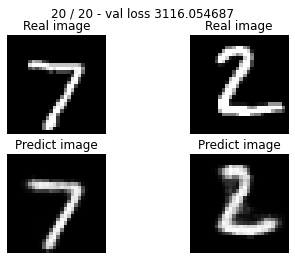

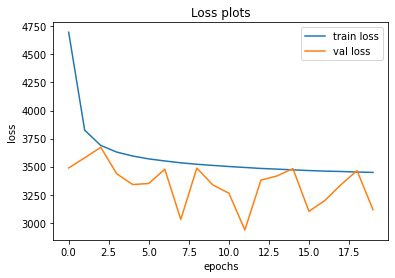

In [ ]:
train_model_vae(autoencoder_vae,optimizer,criterion,train_loader,test_loader)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
autoencoder_vae.eval()
z = torch.tensor(np.array([np.random.normal(0, 1, 13) for i in range(25)]))
output = autoencoder_vae.decode(z.to(device).float())
#<выведите тут полученные картинки>

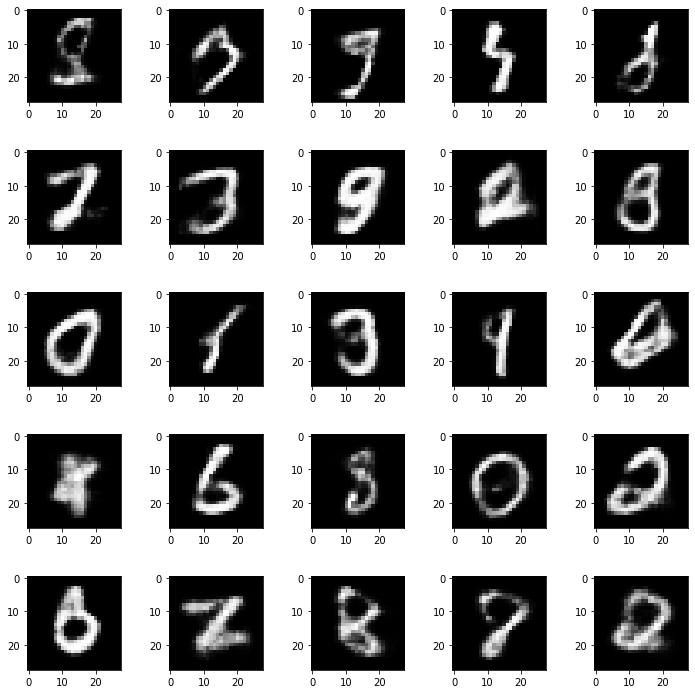

In [ ]:
fig,axes=plt.subplots(5,5,figsize=(10,10))
plt.tight_layout()
for k in range (25):
    axes[k //5][k%5].imshow(output[k].detach().cpu().permute(1,2,0),cmap='gray')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

Что вы думаете о виде латентного представления?

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
vectors=torch.zeros(((len(test_loader)-1)*batch_size,13))
labels=torch.zeros(((len(test_loader)-1)*batch_size))
with torch.no_grad():
    autoencoder_vae.eval()
    for i,(batch,label) in enumerate(test_loader):
        mu,logsigma=autoencoder_vae.encode((batch.to(device).float()))
        latent_vectors=autoencoder_vae.gaussian_sampler(mu,logsigma)
    
        vectors[32*i:32*(i+1)]=latent_vectors
        labels[32*i:32*(i+1)]=label
        if i==(len(test_loader)-2):
            break
        

In [ ]:
latent_vectors_tsne=TSNE(n_components=2,  init='random').fit_transform(vectors)

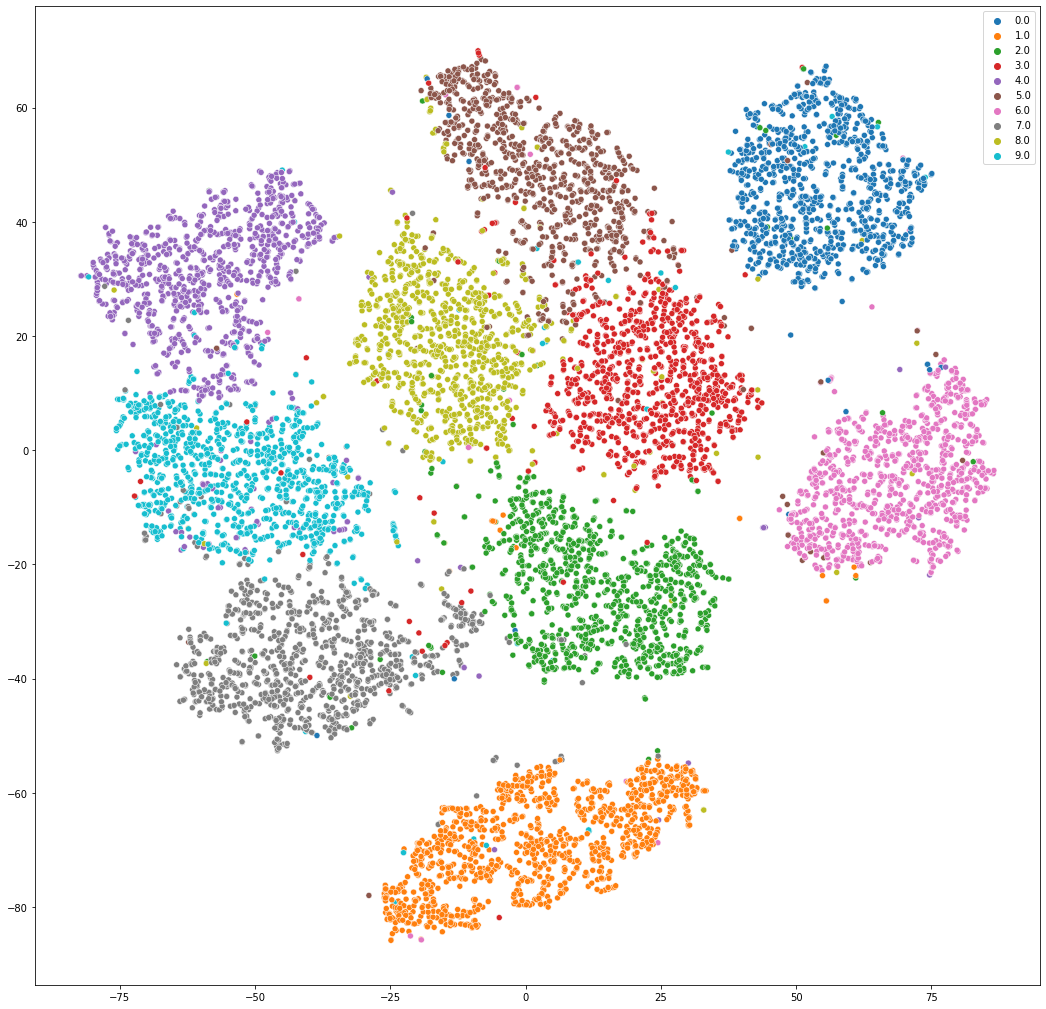

In [ ]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=latent_vectors_tsne[:, 0], y=latent_vectors_tsne[:, 1], hue=labels, 
                    palette="tab10")
plt.show()
    

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
import torch.nn.functional as F

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
  
        self.encoder = nn.Sequential(
            #28x28
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2,  padding=0),
        
         nn.ReLU(),
            #14x14
         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2,  padding=0),
        
         nn.ReLU(),
         #7x7
         nn.Flatten(),
         nn.Linear(3136,26)
        )

    
        self.decoder = nn.Sequential(
            nn.Linear(23,3136),
            nn.Unflatten(dim=1, unflattened_size=(64, 7, 7)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            
            nn.Sigmoid()
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        
        x=x.view(-1,2,13)
        mu = x[:,0,:]
        logsigma = x[:,1,:]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
           
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z,class_num):
        label_vector=F.one_hot(class_num,10)
        vector=torch.cat((z,label_vector),axis=1)
        reconstruction = self.decoder(vector)
        
        return reconstruction

    def forward(self, x,class_num):

        mu, logsigma = self.encode(x)
        latent = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(latent,class_num)
        
        return reconstruction, mu,logsigma

In [ ]:
criterion = loss_vae

autoencoder_cvae = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder_cvae.parameters())

In [ ]:
def train_model_cvae(model,optimizer,criterion,train_dataloader,val_dataloader,epochs=20):
    history={'train_loss':[], 'val_loss':[]}
    for i in range (epochs):
        print (f'^_^ Epoch №{i+1} ^_^')
        avg_loss_train=0
        avg_loss_val=0
        model.train()
        for X,y in train_dataloader:
            X=X.to(device)
            optimizer.zero_grad()
            X_hat,mu,logsigma=model(X,y.to(device))
            loss=criterion(X,mu,logsigma,X_hat)
            loss.backward()
            optimizer.step()
            avg_loss_train+=loss.item()/len(train_dataloader)
        history['train_loss'].append(avg_loss_train)
        with torch.no_grad():
            model.eval()
            for X_val,y_val in val_dataloader:
                X_val=X_val.to(device)  
                X_val_hat,mu,logsigma=model(X,y.to(device))
                loss=criterion(X,mu,logsigma,X_val_hat)
                avg_loss_val+=loss.item()/len(val_dataloader)
        history['val_loss'].append(avg_loss_val)
        print ('Train loss: %.6f \n Val loss: %.6f'% (avg_loss_train,avg_loss_val))
        clear_output(wait=True)
        X_val,y=next(iter(val_dataloader))
        X_val=X_val.to(device) 
        X_val_hat,mu,logsigma=model(X_val,y.to(device))
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3),cmap='gray')
            plt.title('Real image')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(np.rollaxis(X_val_hat[k].detach().cpu().numpy(), 0, 3),cmap='gray')
            plt.title('Predict image')
            plt.axis('off')

        plt.suptitle('%d / %d - val loss %f' % (i+1, epochs, avg_loss_val))
        fig, ax = plt.subplots()
    
        
        ax.plot(history['train_loss'], label='train loss')
        ax.plot(history['val_loss'], label='val loss')
        ax.set_xlabel("epochs")
        ax.set_ylabel("loss")
        ax.legend(loc='best')
        ax.set_title('Loss plots')
        
        
        plt.show()

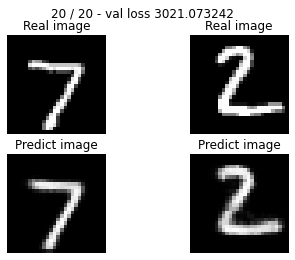

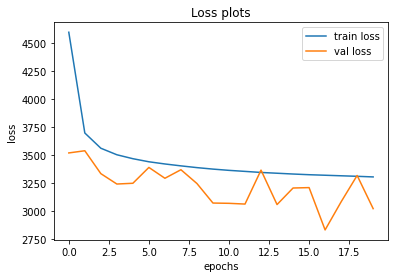

In [ ]:
train_model_cvae(autoencoder_cvae,optimizer,criterion,train_loader,test_loader)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

Нарисуем 5-ку :)

In [ ]:
with torch.no_grad():
    autoencoder_cvae.eval()
    five=torch.tensor([5 for i in range (25)])
    z = torch.tensor(np.array([np.random.normal(0, 1, 13) for i in range(25)]))
    output = autoencoder_cvae.decode(z.to(device).float(),five.to(device))

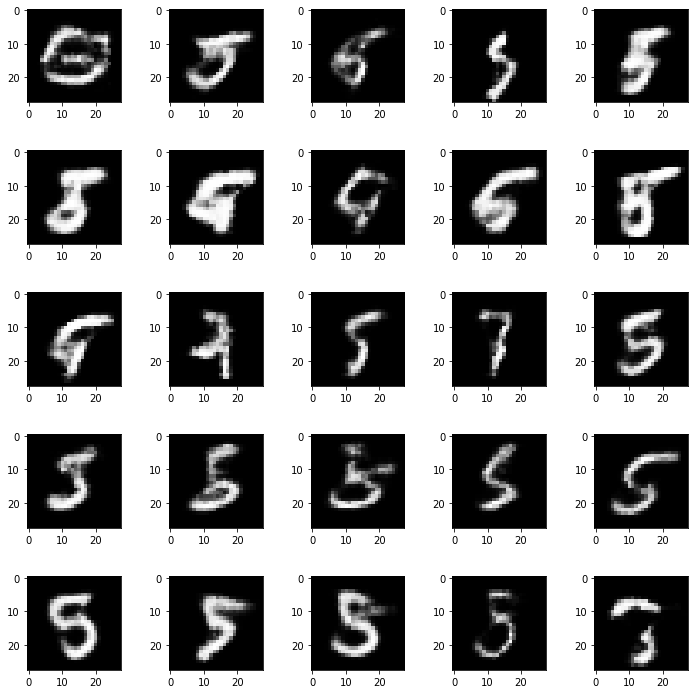

In [ ]:
fig,axes=plt.subplots(5,5,figsize=(10,10))
plt.tight_layout()
for k in range (25):
    axes[k //5][k%5].imshow(output[k].detach().cpu().permute(1,2,0),cmap='gray')

Ну... пойдет :)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
vectors=torch.zeros(((len(test_loader)-1)*batch_size,13))
labels=torch.zeros(((len(test_loader)-1)*batch_size))
with torch.no_grad():
    autoencoder_cvae.eval()
    for i,(batch,label) in enumerate(test_loader):
        mu,logsigma=autoencoder_cvae.encode((batch.to(device).float()))
        latent_vectors=autoencoder_cvae.gaussian_sampler(mu,logsigma)
    
        vectors[32*i:32*(i+1)]=latent_vectors
        labels[32*i:32*(i+1)]=label
        if i==(len(test_loader)-2):
            break
        

In [ ]:
latent_vectors_tsne=TSNE(n_components=2,  init='random').fit_transform(vectors)

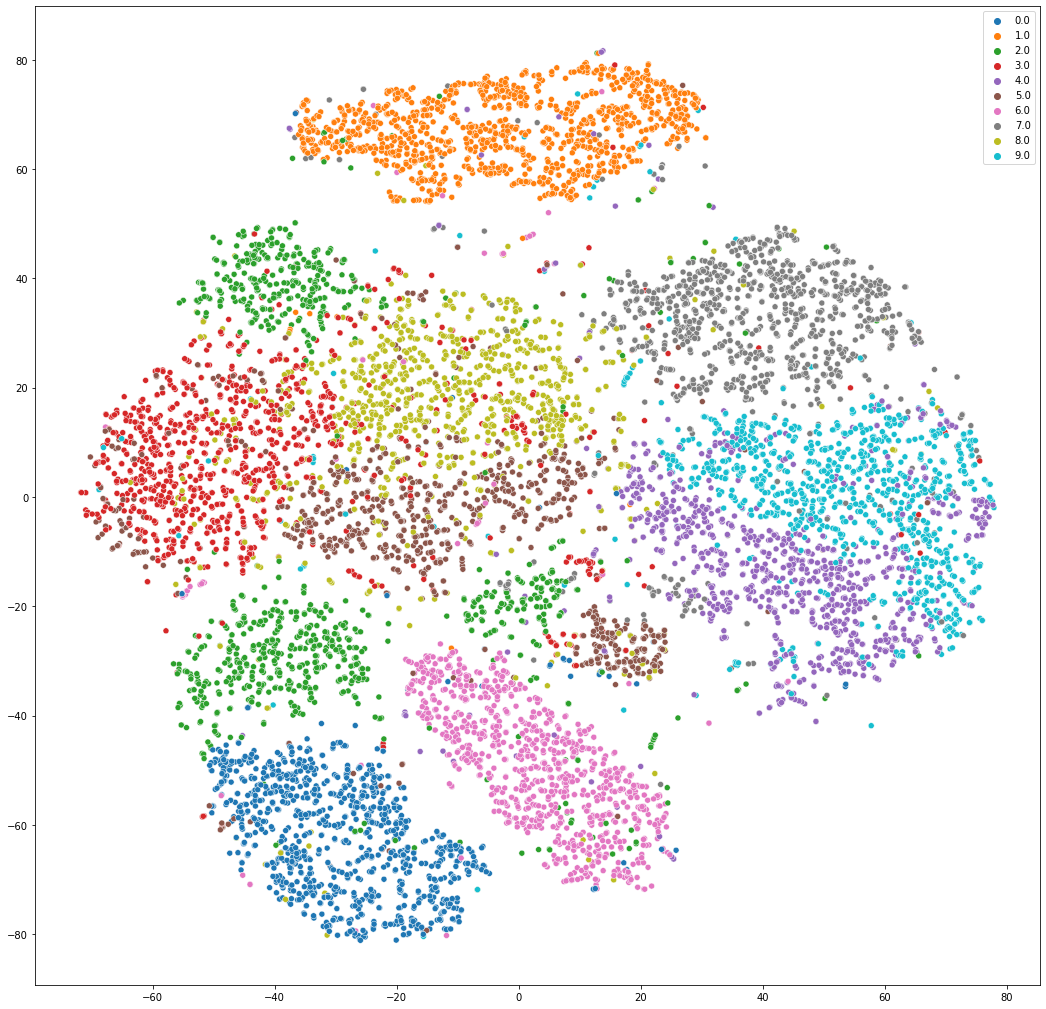

In [ ]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=latent_vectors_tsne[:, 0], y=latent_vectors_tsne[:, 1], hue=labels, 
                    palette="tab10")
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Как видно данные стали располагаться кучнее